In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import pickle

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
submission = pd.read_csv("submission.csv")

In [4]:
train.columns = ['ForecastId', 'Province_State', 'Country_Region', 'Date', 'ConfirmedCases', 'Fatalities']

In [5]:
train.head()

,ForecastId,Province_State,Country_Region,Date,ConfirmedCases,Fatalities
0,1,NaN,Afghanistan,2020-01-22,0.0,0.0
1,2,NaN,Afghanistan,2020-01-23,0.0,0.0
2,3,NaN,Afghanistan,2020-01-24,0.0,0.0
3,4,NaN,Afghanistan,2020-01-25,0.0,0.0
4,5,NaN,Afghanistan,2020-01-26,0.0,0.0


In [6]:
train_date_end = train['Date'].max()
test_date_st = test['Date'].min()

In [7]:
test = test[test['Date'] > train_date_end]

In [8]:
master = train.append(test)

In [9]:
master['Province_State'] = master['Province_State'].fillna('')

In [10]:
master['Country_State'] = master['Country_Region'].str.cat(master['Province_State'],sep=" ")

In [68]:
lockdown_dates = pd.read_csv("lockdown_dates.csv")

In [69]:
lockdown_dates['Country_State'] = lockdown_dates['Country_Region'].str.cat(lockdown_dates.Province_State.fillna(''),sep=" ")

In [13]:
# https://www.bsg.ox.ac.uk/research/research-projects/coronavirus-government-response-tracker

In [70]:
gov_stringency_data = pd.read_csv("OxCGRT_Download_140420_191940_Full.csv")

In [71]:
gov_stringency_data_use = gov_stringency_data[['CountryName','Date','StringencyIndex']]
gov_stringency_data_use['Date'] = pd.to_datetime(gov_stringency_data_use['Date'], format='%Y%m%d').dt.strftime('%Y-%m-%d')

In [72]:
gov_stringency_data_use['CountryName'][gov_stringency_data_use['CountryName'] == 'United States'] = 'US'
gov_stringency_data_use['CountryName'][gov_stringency_data_use['CountryName'] == 'South Korea'] = 'Korea South'
gov_stringency_data_use['CountryName'][gov_stringency_data_use['CountryName'] == 'Myanmar'] = 'Burma'

In [73]:
gov_stringency_data_agg = gov_stringency_data_use[gov_stringency_data_use['StringencyIndex'] >= 50.0].groupby(['CountryName'])['StringencyIndex'].max().reset_index()
#considering an index of above 50 as a serious initiative for lockdown

In [ ]:
gov_stringency_data_use = pd.merge(gov_stringency_data_use, gov_stringency_data_agg
                                   ,how='inner', on=['CountryName'])
gov_stringency_data_use['StringencyIndex_diff_max'] = gov_stringency_data_use['StringencyIndex_x'] - gov_stringency_data_use['StringencyIndex_y']

In [ ]:
gov_stringency_data_agg_use = gov_stringency_data_use[gov_stringency_data_use['StringencyIndex_diff_max'] >= -10.0].groupby(['CountryName'])['Date'].min().reset_index()
gov_stringency_data_agg_use.columns = ['Country_Region', 'Stringency_Date']

In [75]:
lockdown_dates_upd = pd.merge(lockdown_dates, gov_stringency_data_agg_use
                              ,how='left', on=['Country_Region'])

In [20]:
#lockdown_dates_upd.to_csv("lockdown_dates_upd.csv", index=False)

In [76]:
lockdown_dates_upd['Lockdown_date_use'] = ''
lockdown_dates_upd['Lockdown_date_use'][lockdown_dates_upd['Country_Region'].isin(['US','China','Australia']) == True] = lockdown_dates_upd['Lockdown_date']
lockdown_dates_upd['Lockdown_date_use'][lockdown_dates_upd['Country_Region'].isin(['US','China','Australia']) == False] = lockdown_dates_upd['Stringency_Date'].combine_first(lockdown_dates_upd['Lockdown_date'])
#for some countries, state level lockdown dates are more accurate


In [22]:
def cc_model_poly(dataset,start_date,end_date,start_value,Country_State,knot_number):
    dataset = dataset[(dataset['Date'] >= start_date) & (dataset['Date'] <= end_date)]
    dataset['Date_diff'] = (((pd.to_datetime(dataset['Date']) - pd.to_datetime(start_date)).dt.days))
    dataset['Date_diff_p2'] = dataset['Date_diff']**2
    dataset['Date_diff_p3'] = dataset['Date_diff']**3
    input_columns = ['Date_diff','Date_diff_p2','Date_diff_p3']
    
    if len(dataset.dropna()) > 5:
        start_value = dataset['ConfirmedCases_inc'].values[0]
        dataset['ConfirmedCases_inc_use'] = dataset['ConfirmedCases_inc_sm']
        reg = LinearRegression().fit(dataset.dropna()[input_columns], dataset.dropna()['ConfirmedCases_inc_use'])
        dataset['ConfirmedCases_pred'] = reg.predict(dataset[input_columns])
#         print(reg.score(dataset.dropna()[input_columns], dataset.dropna()['ConfirmedCases_inc_use']))
#         print(reg.coef_, reg.intercept_)
        filename = 'cc_'+Country_State+'_'+knot_number+'.sav'
        pickle.dump(reg, open(filename, 'wb'))
    else:
        print('..picking fallback cc model for knot '+knot_number+' ..')
        reg = pickle.load(open('cc_China Hubei'+'_'+knot_number+'.sav', 'rb'))
#         print(reg.coef_, reg.intercept_)
        dataset['ConfirmedCases_pred'] = reg.predict(dataset[input_columns]) - reg.intercept_ + start_value

#     outlier treatment for middle knot
    if knot_number == '2':
        cap_upper = dataset['ConfirmedCases_inc'].mean() + (dataset['ConfirmedCases_inc'].std())
        cap_lower = dataset['ConfirmedCases_inc'].mean() - (dataset['ConfirmedCases_inc'].std())
        dataset['ConfirmedCases_pred'] = dataset['ConfirmedCases_pred'].clip(lower=cap_lower, upper=cap_upper)
    
    dataset['ConfirmedCases_pred'][dataset['ConfirmedCases_pred'] < 0] = 0
    return(dataset)

In [23]:
def cc_model_exp(dataset,start_date,end_date,start_value,Country_State,knot_number):
    dataset = dataset[(dataset['Date'] >= start_date) & (dataset['Date'] <= end_date)]
    dataset['Date_diff'] = (((pd.to_datetime(dataset['Date']) - pd.to_datetime(start_date)).dt.days))
#     input_columns = [['Date_diff']]
    
    if len(dataset.dropna()) > 5:
        dataset['ConfirmedCases_inc_use'] = dataset['ConfirmedCases_inc_sm'] + 0.0001 # to avoid infinity values from log(0)
        reg = LinearRegression().fit(dataset.dropna()[['Date_diff']], np.log(dataset.dropna()['ConfirmedCases_inc_use']))
        dataset['ConfirmedCases_pred'] = np.exp(reg.predict(dataset[['Date_diff']]))
#         print(reg.score(dataset.dropna()[['Date_diff']], dataset.dropna()['ConfirmedCases_inc_use']))
#         print(reg.coef_, reg.intercept_)
        filename = 'cc_'+Country_State+'_'+knot_number+'.sav'
        pickle.dump(reg, open(filename, 'wb'))
    else:
        print('..picking fallback cc model for knot '+knot_number+' ..')
        reg = pickle.load(open('cc_China Hubei'+'_'+knot_number+'.sav', 'rb'))
#         print(reg.coef_, reg.intercept_)
        dataset['ConfirmedCases_pred'] = np.exp(reg.predict(dataset[['Date_diff']]) - reg.intercept_ + np.log(start_value))
    
    if reg.coef_ > 0:
        # instances where confirmed cases are increasing even after significant lockdown, it is not ideal to fit the last knot into an exponential model, hence calling poly model
        print('..picking polynomial model instead of exp for knot '+knot_number+' ..')
        dataset = cc_model_poly(dataset,start_date,end_date,start_value,Country_State,knot_number)

    return(dataset)

In [24]:
def fa_model_lnr(dataset,Country_State):
    dataset['ConfirmedCases_lagn'] = dataset['ConfirmedCases'].shift(periods=5)
    dataset['ConfirmedCases_pred_lagn'] = dataset['ConfirmedCases_pred'].shift(periods=5).fillna(0)
    
    if len(dataset.dropna()) > 10:
        reg = LinearRegression(fit_intercept=False).fit(dataset.dropna()[['ConfirmedCases_lagn']], dataset.dropna()['Fatalities'])
        dataset['Fatalities_pred'] = reg.predict(dataset[['ConfirmedCases_pred_lagn']])
#         print(reg.score(dataset.dropna()[['ConfirmedCases_lagn']], dataset.dropna()['Fatalities']))
#         print(reg.coef_, reg.intercept_)
        filename = 'fa_'+Country_State+'_'+'.sav'
        pickle.dump(reg, open('model_objects/'+filename, 'wb'))
    else:
        print('..picking fallback fa model..')
        loaded_model = pickle.load(open('model_objects/fa_China Hubei'+'_'+'.sav', 'rb'))
#         print(loaded_model.coef_, loaded_model.intercept_)
        dataset['Fatalities_pred'] = loaded_model.predict(dataset[['ConfirmedCases_pred_lagn']])

    return(dataset)

In [48]:
def cc_plot_outputs(dataset):
    fig = plt.figure()
    plt.ioff()
    fig.set_size_inches(18.5, 10.5)
    plt.plot(dataset['Date'], dataset['ConfirmedCases_inc'], marker='o', color='lightgreen')
    plt.plot(dataset['Date'], dataset['ConfirmedCases_pred'], color='r')
    fig.savefig('plots/cc/'+Country_State+'.jpg')
#     plt.close(fig)

In [49]:
def fa_plot_outputs(dataset):
    fig = plt.figure()
    plt.ioff()
    fig.set_size_inches(18.5, 10.5)
    plt.plot(dataset['Date'], dataset['Fatalities'], marker='o', color='lightgreen')
    plt.plot(dataset['Date'], dataset['Fatalities_pred'], color='r')
    fig.savefig('plots/fa/'+Country_State+'.jpg')
#     plt.close(fig)

In [27]:
# ['China Hubei'] + master['Country_State'].unique().tolist()

In [28]:
test_update = pd.DataFrame(columns = ['Province_State', 'Country_Region', 'Date', 'ConfirmedCases_pred' ,'Fatalities_pred'])
for Country_State in ['China Hubei'] + master['Country_State'].unique().tolist():
    print('running for: '+Country_State)
    master_use = master[master['Country_State'] == Country_State]
    master_use['ConfirmedCases_inc'] = master_use['ConfirmedCases'] - master_use['ConfirmedCases'].shift(periods=1).fillna(0)
    master_use['ConfirmedCases_inc_sm'] = master_use['ConfirmedCases_inc'].rolling(window=5,center=True,min_periods=1).mean()

    st_dt = master_use['Date'][master_use['ConfirmedCases'] > 0].min()
    mx_dt = master_use['Date'].max()
    ld_dt = lockdown_dates_upd['Lockdown_date_use'][lockdown_dates_upd['Country_State'] == Country_State].values[0]
    
    try:    
        if (ld_dt != '9999-12-31'): # countries with lockdown imposed
            add_wdw = 3
            kt_1p = (pd.to_datetime(ld_dt)+dt.timedelta(days=14+add_wdw)).strftime("%Y-%m-%d")
            kt_1m = (pd.to_datetime(ld_dt)+dt.timedelta(days=14-add_wdw)).strftime("%Y-%m-%d")
            kt_2p = (pd.to_datetime(ld_dt)+dt.timedelta(days=28+add_wdw)).strftime("%Y-%m-%d")
            kt_2m = (pd.to_datetime(ld_dt)+dt.timedelta(days=28-add_wdw)).strftime("%Y-%m-%d")

            a = cc_model_poly(master_use, st_dt, kt_1p, 0, Country_State, '1')
            b = cc_model_poly(master_use, kt_1m, kt_2p, a.tail(1)['ConfirmedCases_pred'].values[0], Country_State, '2')
            c = cc_model_exp(master_use, kt_2m, mx_dt, b.tail(1)['ConfirmedCases_pred'].values[0], Country_State, '3')
            master_use = a.append(b).append(c)
            master_use = master_use.groupby(['Province_State', 'Country_Region', 'Date', 'Country_State'])['ConfirmedCases', 'ConfirmedCases_pred', 'ConfirmedCases_inc', 'Fatalities'].mean().reset_index()
            cc_plot_outputs(master_use)

        else: # countries with no lockdown. uses only one model
            master_use = cc_model_poly(master_use, st_dt, mx_dt, 0, Country_State, '1')
            cc_plot_outputs(master_use)

        # update dataset for fatalities model
        master_use['ConfirmedCases_pred'] = master_use['ConfirmedCases_inc'].combine_first(master_use['ConfirmedCases_pred'])
        master_use['ConfirmedCases_pred'] = master_use['ConfirmedCases_pred'].cumsum()

        master_use = fa_model_lnr(master_use, Country_State)
        fa_plot_outputs(master_use)
        
        master_use['Fatalities_pred'] = master_use['Fatalities'].combine_first(master_use['Fatalities_pred'])
        test_use = master_use[master_use['Date'] >= test_date_st]
        test_update = test_update.append(test_use[['Province_State', 'Country_Region', 'Date', 'ConfirmedCases_pred', 'Fatalities_pred']])

    
    except:
        print('exiting due to error')
        pass

running for: China Hubei
running for: Afghanistan 
..picking fallback cc model..
running for: Albania 
running for: Algeria 
..picking fallback cc model..
running for: Andorra 
..picking fallback cc model..
running for: Angola 
..picking fallback cc model..
running for: Antigua and Barbuda 
running for: Argentina 
..picking fallback cc model..
running for: Armenia 
..picking fallback cc model..
running for: Australia Australian Capital Territory
..picking fallback cc model..
running for: Australia New South Wales
..picking fallback cc model..
running for: Australia Northern Territory
..picking fallback cc model..
running for: Australia Queensland
..picking fallback cc model..
..picking fallback cc model..
running for: Australia South Australia
..picking fallback cc model..
running for: Australia Tasmania
..picking fallback cc model..
running for: Australia Victoria
..picking fallback cc model..
running for: Australia Western Australia
..picking fallback cc model..
running for: Austria 

..picking fallback cc model..
running for: Netherlands 
..picking fallback cc model..
running for: New Zealand 
..picking fallback cc model..
running for: Nicaragua 
running for: Niger 
..picking fallback cc model..
running for: Nigeria 
..picking fallback cc model..
running for: North Macedonia 
running for: Norway 
running for: Oman 
..picking fallback cc model..
running for: Pakistan 
..picking fallback cc model..
running for: Panama 
..picking fallback cc model..
running for: Papua New Guinea 
..picking fallback cc model..
running for: Paraguay 
..picking fallback cc model..
running for: Peru 
running for: Philippines 
running for: Poland 
running for: Portugal 
..picking fallback cc model..
running for: Qatar 
running for: Romania 
running for: Russia 
..picking fallback cc model..
running for: Rwanda 
..picking fallback cc model..
running for: Saint Kitts and Nevis 
..picking fallback cc model..
running for: Saint Lucia 
running for: Saint Vincent and the Grenadines 
running for:

In [29]:
master_use.columns

Index(['Province_State', 'Country_Region', 'Date', 'Country_State',
       'ConfirmedCases', 'ConfirmedCases_pred', 'ConfirmedCases_inc',
       'Fatalities', 'ConfirmedCases_lagn', 'ConfirmedCases_pred_lagn',
       'Fatalities_pred'],
      dtype='object')

In [30]:
missing_inst = list(set(master['Country_State'].unique())-set(test_update['Country_Region'].str.cat(test_update['Province_State'],sep=" ").unique()))

In [31]:
for Country_State in missing_inst:
    print('running for: '+Country_State)
    master_use = master[master['Country_State'] == Country_State]
    
    cc_ext = master_use['ConfirmedCases'].max()
    fa_ext = master_use['Fatalities'].max()
    master_use['ConfirmedCases_pred'] = cc_ext
    master_use['Fatalities_pred'] = fa_ext
    
    master_use['ConfirmedCases_pred'] = master_use['ConfirmedCases'].combine_first(master_use['ConfirmedCases_pred'])
    test_use = master_use[master_use['Date'] >= test_date_st]
    test_update = test_update.append(test_use[['Province_State', 'Country_Region', 'Date', 'ConfirmedCases_pred', 'Fatalities_pred']])

running for: China Guizhou
running for: Burundi 
running for: Netherlands Bonaire, Sint Eustatius and Saba
running for: Sao Tome and Principe 
running for: Western Sahara 
running for: Mongolia 
running for: France Saint Pierre and Miquelon
running for: MS Zaandam 


In [32]:
test_update = test_update.groupby(['Province_State', 'Country_Region', 'Date'])['ConfirmedCases_pred','Fatalities_pred'].max().reset_index()

In [33]:
test_orig = pd.read_csv("test.csv")
test_orig['Province_State'] = test_orig['Province_State'].fillna('')

In [34]:
sub = pd.merge(test_orig[['ForecastId','Province_State','Country_Region', 'Date']], test_update[['Province_State','Country_Region', 'Date', 'ConfirmedCases_pred','Fatalities_pred']], how='left', on=['Province_State','Country_Region', 'Date'])

In [35]:
sub['ConfirmedCases_pred'] = sub['ConfirmedCases_pred'].fillna(0)
sub['Fatalities_pred'] = sub['Fatalities_pred'].fillna(0)

In [93]:
sub[sub['ForecastId'] == 7267]

,ForecastId,Province_State,Country_Region,Date,ConfirmedCases_pred,Fatalities_pred
7266,7267,,Maldives,2020-05-14,19.0033,0.0


In [37]:
# sub = sub[['ForecastId','ConfirmedCases_pred','Fatalities_pred']]

In [38]:
# sub.columns = submission.columns

In [39]:
#sub.to_csv("submission.csv",index=False)

In [40]:
# for dirname, _, filenames in os.walk('..'):
#     for filename in filenames:
#         if filename.lower().endswith('.sav'):
#             os.remove(os.path.join(dirname, filename))

running for: Maldives 


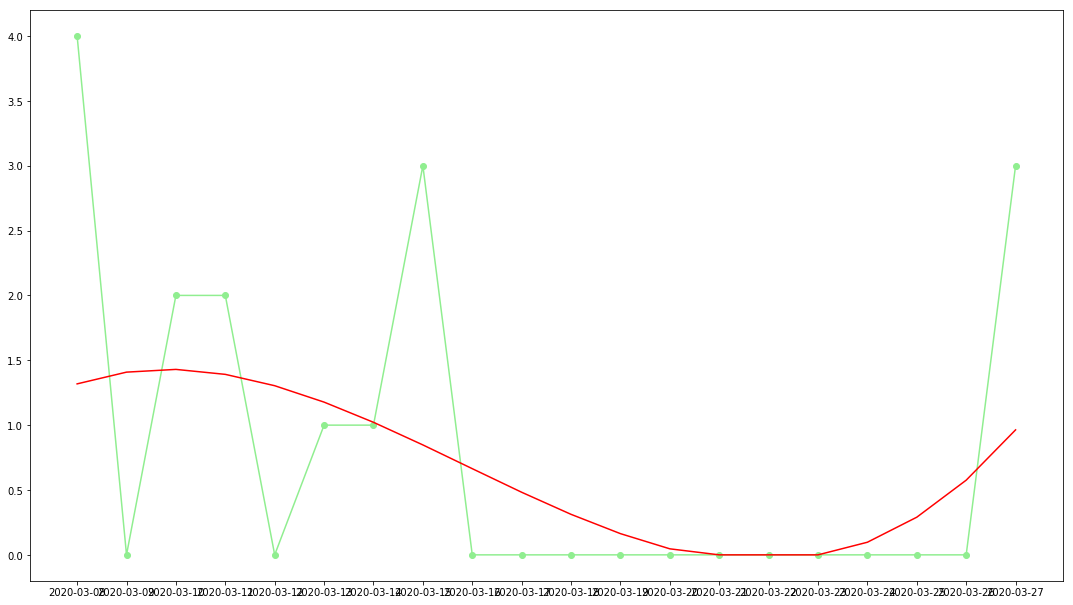

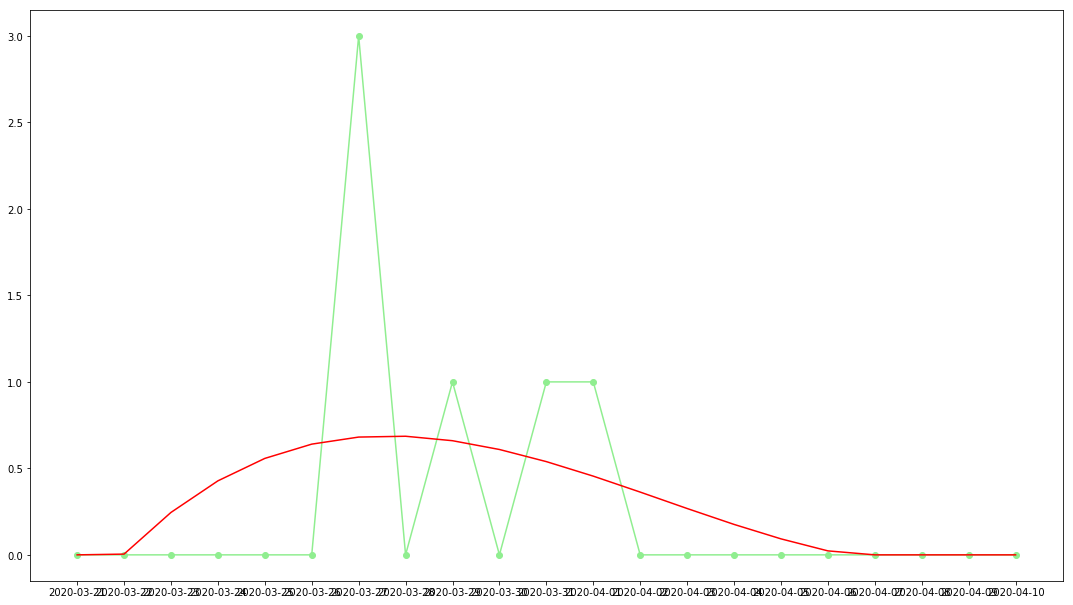

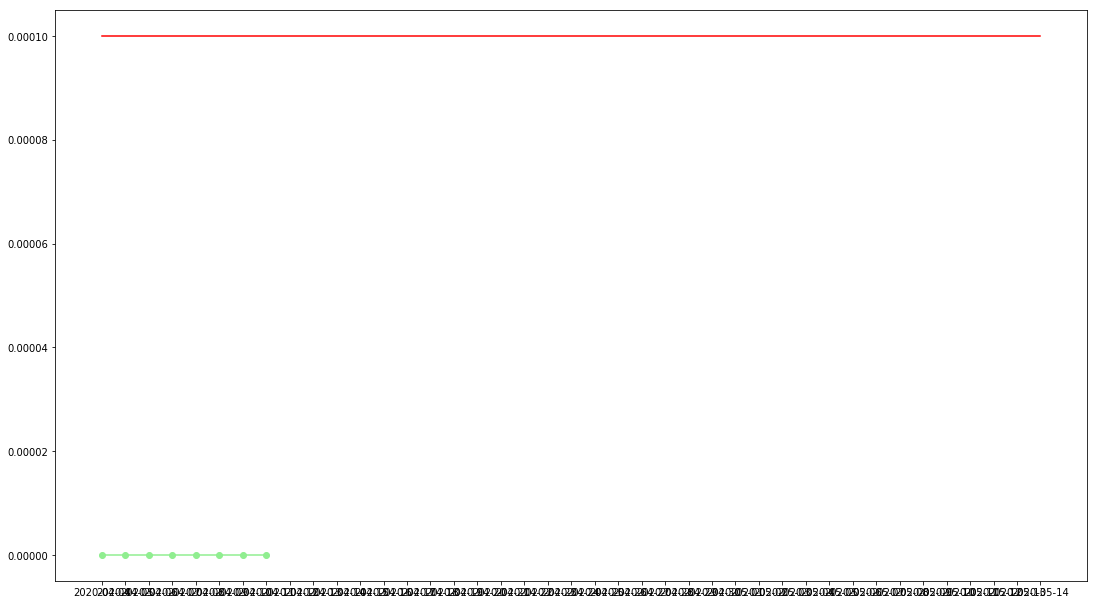

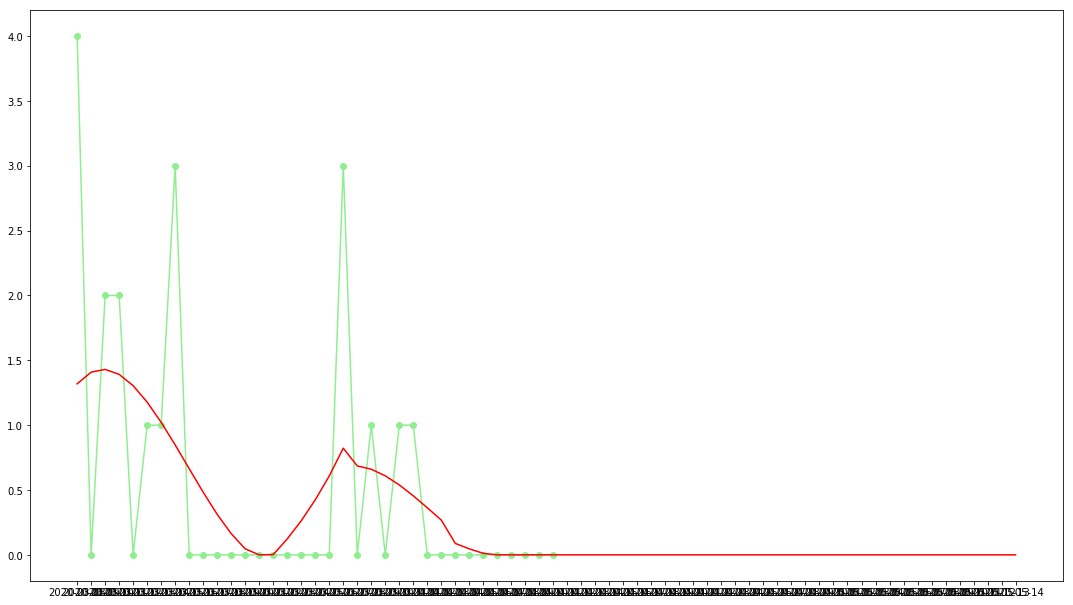

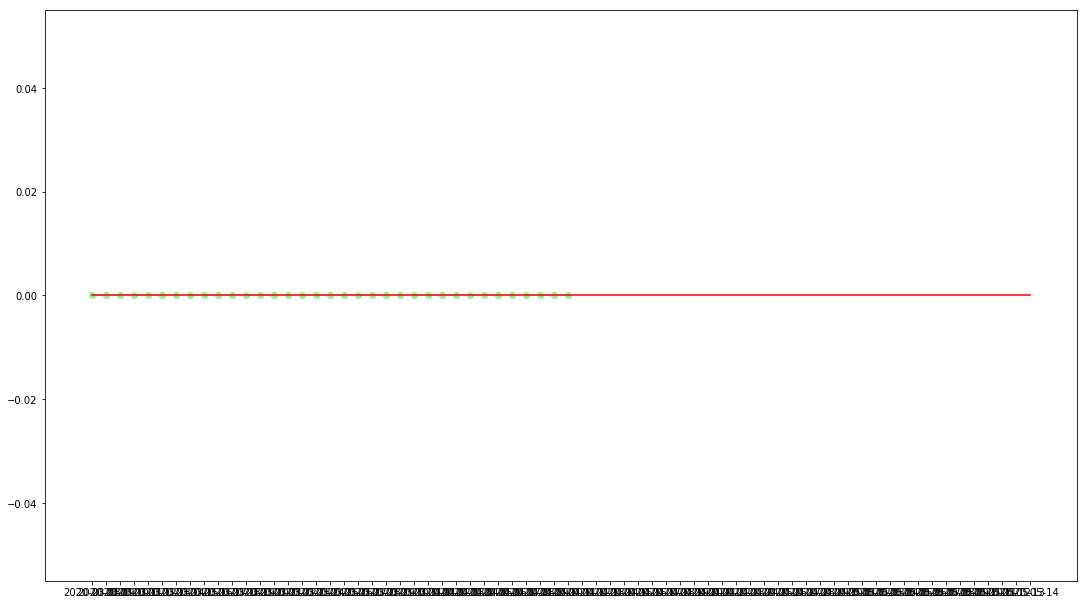

In [94]:
for Country_State in ['Maldives ']:
    print('running for: '+Country_State)
    master_use = master[master['Country_State'] == Country_State]
    master_use['ConfirmedCases_inc'] = master_use['ConfirmedCases'] - master_use['ConfirmedCases'].shift(periods=1).fillna(0)
    master_use['ConfirmedCases_inc_sm'] = master_use['ConfirmedCases_inc'].rolling(window=5,center=True,min_periods=1).mean()

    st_dt = master_use['Date'][master_use['ConfirmedCases'] > 0].min()
    mx_dt = master_use['Date'].max()
    ld_dt = lockdown_dates_upd['Lockdown_date_use'][lockdown_dates_upd['Country_State'] == Country_State].values[0]
    
    try:    
        if (ld_dt != '9999-12-31'): # countries with lockdown imposed
            add_wdw = 3
            kt_1p = (pd.to_datetime(ld_dt)+dt.timedelta(days=14+add_wdw)).strftime("%Y-%m-%d")
            kt_1m = (pd.to_datetime(ld_dt)+dt.timedelta(days=14-add_wdw)).strftime("%Y-%m-%d")
            kt_2p = (pd.to_datetime(ld_dt)+dt.timedelta(days=28+add_wdw)).strftime("%Y-%m-%d")
            kt_2m = (pd.to_datetime(ld_dt)+dt.timedelta(days=28-add_wdw)).strftime("%Y-%m-%d")

            a = cc_model_poly(master_use, st_dt, kt_1p, 0, Country_State, '1')
            b = cc_model_poly(master_use, kt_1m, kt_2p, a.tail(1)['ConfirmedCases_pred'].values[0], Country_State, '2')
            c = cc_model_exp(master_use, kt_2m, mx_dt, b.tail(1)['ConfirmedCases_pred'].values[0], Country_State, '3')
            master_use = a.append(b).append(c)
            master_use = master_use.groupby(['Province_State', 'Country_Region', 'Date', 'Country_State'])['ConfirmedCases', 'ConfirmedCases_pred', 'ConfirmedCases_inc', 'Fatalities'].mean().reset_index()
            cc_plot_outputs(a)
            cc_plot_outputs(b)
            cc_plot_outputs(c)
            cc_plot_outputs(master_use)

        else: # countries with no lockdown. uses only one model
            master_use = cc_model_poly(master_use, st_dt, mx_dt, 0, Country_State, '1')
            cc_plot_outputs(master_use)

        # update dataset for fatalities model
        master_use['ConfirmedCases_pred'] = master_use['ConfirmedCases_inc'].combine_first(master_use['ConfirmedCases_pred'])
        master_use['ConfirmedCases_pred'] = master_use['ConfirmedCases_pred'].cumsum()

        master_use = fa_model_lnr(master_use, Country_State)
        fa_plot_outputs(master_use)
        
        master_use['Fatalities_pred'] = master_use['Fatalities'].combine_first(master_use['Fatalities_pred'])
#         test_use = master_use[master_use['Date'] >= test_date_st]
#         test_update = test_update.append(test_use[['Province_State', 'Country_Region', 'Date', 'ConfirmedCases_pred', 'Fatalities_pred']])

    
    except:
        print('exiting due to error')
        pass

updates:
1. changed name for Burma in the Stringent file
2. updated lockdown date for ..
3. updated lockdown date for Cabo Verde
4. no lockdown date for Central African Republic
5. no lockdown date for Equatorial Guinea
6. changed exp model for Japan, knot 3
7. unable to fix Kosovo
8. updated lockdown date for Maldives